<a href="https://colab.research.google.com/github/ShotaArima/task-wind-to-ep/blob/main/Final_Task(iwano_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 目標
横浜キャンパスの車両門付記に設置されている2機の風車の「合計の発電量」を、「風速」などの情報からニューラルネットワークを利用して予測（推定）する

## 使用データ
- 2023年2月28日～5月30日のうち，風車を稼働させていた
  - 55日分の実測データを利用各日8回（11:00, 12:00, ..., 18:00時点）の観
  - データを利用合計55日×8回＝440個のサンプル

### 説明
- `wind_data_s.csv` では、風速のみのデータ
  - no. 0～303 が4月までの38日分のデータ（学習に使用）
  - no. 304～439 が5月の17日分のデータ（評価に使用）
  - 変数
    - `x1` :その時刻の風速（m/s）
    - `x2` :1時間前の風速（m/s）
    - `y` : 発電量（W）

- `wind_data_sd.csv` では風向きの情報を追加
  - 変数
    - `x3`:その時刻の風向き（度）
    - `x4`:1時間前の風向き（度）

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# モジュールのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.api.models import Sequential
from keras.api.layers import Dense
from sklearn.preprocessing import MinMaxScaler

In [19]:
# データの読み込み
f = open('/content/drive/MyDrive/class/知能科学/wind_data_s.csv')
df = pd.read_csv(f)
xy = df.loc[:,['x1', 'x2', 'y']].values

In [20]:
# データの正規化
scaler = MinMaxScaler()
norm_xy = scaler.fit_transform(xy)
#print(norm_xy)

# 学習データと評価データの準備
norm_x = norm_xy[:, 0:2]
norm_y = norm_xy[:, 2]
x_train = norm_x[:304]
x_test = norm_x[304:440]
y_train = norm_y[:304]
y_test = norm_y[304:440]
#print(x_train)
#print(x_train.shape)
#print(y_train)
#print(y_train.shape)
#print(x_test)
#print(x_test.shape)
#print(y_test)
#print(y_test.shape)

## ニューラルネットワークの構築

In [21]:
# ニューラルネットワークの構築
input_nnode = 2    # 入力層のノード数
mid1_nnode = 4     # １番目の中間層のノード数
#mid2_nnode = 2     # ２番目の中間層のノード数
output_nnode = 1   # 出力層のノード数
model = Sequential()
model.add(Dense(mid1_nnode, activation='relu', input_dim=input_nnode))
#model.add(Dense(mid2_nnode, activation='relu'))
model.add(Dense(output_nnode, activation='linear'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

## 最適化
- 最適化アルゴリズム: Adam
- 損失関数: 平均二乗誤差（mean_squared_error）を利用
  - 平均絶対誤差（mean_absolute_error）は参考のために表示ミニバッチ最適化を利用
- バッチサイズ: 8
- エポック数: 300

In [22]:
# ネットワークの最適化（学習）
model.compile(optimizer='adam',
   loss='mean_squared_error',
   metrics=['mean_absolute_error'])

train_history = model.fit(x_train, y_train,
   batch_size=8,
   epochs=300,
   verbose=1,
   validation_data=(x_test, y_test))

Epoch 1/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1055 - mean_absolute_error: 0.2597 - val_loss: 0.0281 - val_mean_absolute_error: 0.1292
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927 - mean_absolute_error: 0.1893 - val_loss: 0.0127 - val_mean_absolute_error: 0.0774
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0448 - mean_absolute_error: 0.1261 - val_loss: 0.0096 - val_mean_absolute_error: 0.0681
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285 - mean_absolute_error: 0.1090 - val_loss: 0.0106 - val_mean_absolute_error: 0.0777
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323 - mean_absolute_error: 0.1236 - val_loss: 0.0119 - val_mean_absolute_error: 0.0876
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 - mean_absolute_error: 0.1214 - val_loss: 0.0120 - val_mean_absolute_error: 0.0900
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 - mean_absolute_error: 0.1278 - val_loss

## 結果の表示

{'loss': [0.10771062225103378, 0.06419771909713745, 0.042952511459589005, 0.03490481525659561, 0.03221695125102997, 0.030756955966353416, 0.029669582843780518, 0.028495563194155693, 0.027428021654486656, 0.02632788009941578, 0.025342436507344246, 0.024387119337916374, 0.023186514154076576, 0.02223295345902443, 0.021127361804246902, 0.02013060636818409, 0.01911025308072567, 0.017808988690376282, 0.016371069476008415, 0.015029214322566986, 0.013987986370921135, 0.013193221762776375, 0.012505901046097279, 0.011786864139139652, 0.011302710510790348, 0.010845706798136234, 0.010501802898943424, 0.010156325995922089, 0.009994646534323692, 0.009764586575329304, 0.009584110230207443, 0.009430049918591976, 0.009345459751784801, 0.009233187884092331, 0.009122314862906933, 0.00902907457202673, 0.00892691034823656, 0.008875269442796707, 0.008793707937002182, 0.008743134327232838, 0.00867655873298645, 0.008695212192833424, 0.008722372353076935, 0.008573612198233604, 0.008501177653670311, 0.008538240

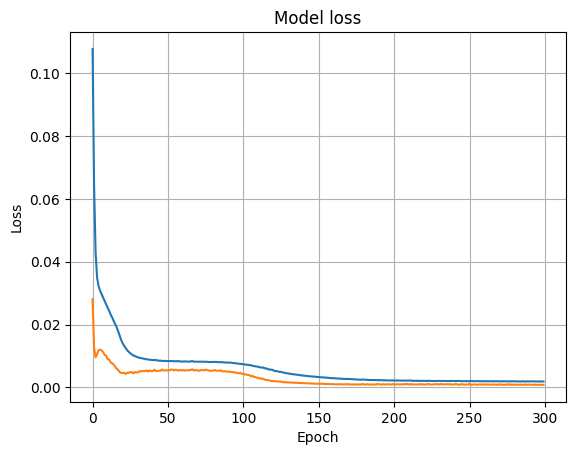

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[ 5.19847322e+00  1.32809094e+01  4.41470487e+00  3.38192125e+00
  3.06518076e+00  2.67038102e+00  2.43124897e+01  7.34381148e+00
  1.45448307e+01  4.41470487e+00  9.87165195e+00  8.60773206e+00
  3.86378677e+00  3.05315037e+00  3.46448445e+00  2.66587793e+00
  4.48695235e-01  6.91879198e-01  4.44191635e-01  2.18851583e+00
  3.22129929e+00  3.06968385e+00  1.56404155e+00  8.43494810e-01
  1.55953847e+00  1.79371609e+00  2.50975923e+00  2.58781850e+00
  2.74844028e+00  2.43169980e+00  2.27107836e+00  2.58781850e+00
 -1.48311384e-01  2.10013673e-01  1.39441300e+00  2.90455881e+00
  3.22129929e+00  3.30386181e+00  2.82649954e+00  1.07142620e+01
 -6.93499267e-01 -6.16813481e-01 -1.40522748e-01 -3.32836814e-01
  1.71115374e+00  2.98712167e+00  2.50975923e+00  1.96334439e+00
  2.06371173e-02  9.99613509e-01  1.80272260e+00  7.65435547e-01
  1.39891634e+00  1.95433787e+00  2.03690074e+00  1.55953847e+00
  7.65435547e-01  1.32085716e+00  1.63759756e+00  1.

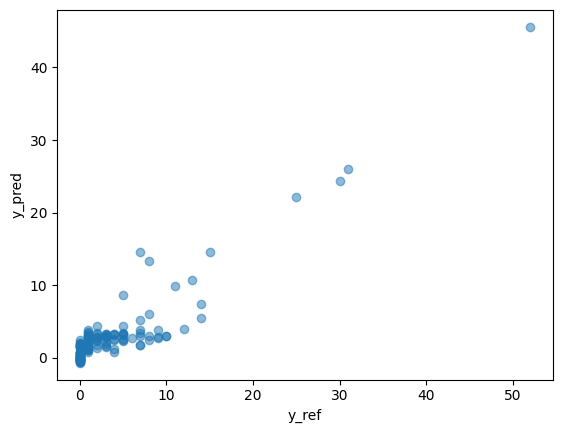

In [23]:
# 学習経過の表示
train_history.history.keys()
print(train_history.history)
len(train_history.history['loss'])

# 損失関数値のプロット
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

# 評価データによる推定と逆正規化
norm_y_pred = model.predict(x_test)
#print(norm_y_pred)
norm_xy_pred = np.hstack((x_test, norm_y_pred))
xy_pred = scaler.inverse_transform(norm_xy_pred)

# 最終的な推定値と正解値の表示
y_pred = xy_pred[:, 2]
y_ref = xy[304:440, 2]
print(y_pred)
print(y_ref)
fig, ax = plt.subplots()
ax.scatter(y_ref, y_pred, alpha=0.5)
ax.set_xlabel('y_ref')
ax.set_ylabel('y_pred')
plt.show()